## Download The Dataset

In [1]:
!pip install xgboost

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/optimizing-operating-room-utilization")

print("Path to dataset files:", path)

/home/udara/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/udara/.cache/kagglehub/datasets/thedevastator/optimizing-operating-room-utilization/versions/2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Import Dataset

In [4]:
df = pd.read_csv('/home/udara/Agentic-Project/data/2022_Q1_OR_Utilization.csv')

In [5]:
print(df.columns)  

Index(['index', 'Encounter ID', 'Date', 'OR Suite', 'Service', 'CPT Code',
       'CPT Description', 'Booked Time (min)', 'OR Schedule', 'Wheels In',
       'Start Time', 'End Time', 'Wheels Out'],
      dtype='object')


In [6]:
print(df.info())    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              2172 non-null   int64 
 1   Encounter ID       2172 non-null   int64 
 2   Date               2172 non-null   object
 3   OR Suite           2172 non-null   int64 
 4   Service            2172 non-null   object
 5   CPT Code           2172 non-null   int64 
 6   CPT Description    2172 non-null   object
 7   Booked Time (min)  2172 non-null   int64 
 8   OR Schedule        2172 non-null   object
 9   Wheels In          2172 non-null   object
 10  Start Time         2172 non-null   object
 11  End Time           2172 non-null   object
 12  Wheels Out         2172 non-null   object
dtypes: int64(5), object(8)
memory usage: 220.7+ KB
None


In [7]:
print(df.isnull().sum()) 

index                0
Encounter ID         0
Date                 0
OR Suite             0
Service              0
CPT Code             0
CPT Description      0
Booked Time (min)    0
OR Schedule          0
Wheels In            0
Start Time           0
End Time             0
Wheels Out           0
dtype: int64


In [8]:
print(df.head())

   index  Encounter ID      Date  OR Suite      Service  CPT Code  \
0      0         10001  01/03/22         1     Podiatry     28110   
1      1         10002  01/03/22         1     Podiatry     28055   
2      2         10003  01/03/22         1     Podiatry     28297   
3      3         10004  01/03/22         1     Podiatry     28296   
4      4         10005  01/03/22         2  Orthopedics     27445   

                             CPT Description  Booked Time (min)  \
0   Partial ostectomy, fifth metatarsal head                 90   
1  Neurectomy, intrinsic musculature of foot                 60   
2                       Lapidus bunionectomy                150   
3         Bunionectomy with distal osteotomy                120   
4        Arthroplasty, knee, hinge prothesis                120   

         OR Schedule          Wheels In         Start Time           End Time  \
0  01/03/22 07:00 AM  01/03/22 07:05 AM  01/03/22 07:32 AM  01/03/22 09:05 AM   
1  01/03/22 08:45 AM

In [10]:
df['Wheels In'] = pd.to_datetime(df['Wheels In'])
df['Wheels Out'] = pd.to_datetime(df['Wheels Out'])
df['actual_duration_min'] = (df['Wheels Out'] - df['Wheels In']).dt.total_seconds() / 60

In [11]:
print(df)

      index  Encounter ID      Date  OR Suite      Service  CPT Code  \
0         0         10001  01/03/22         1     Podiatry     28110   
1         1         10002  01/03/22         1     Podiatry     28055   
2         2         10003  01/03/22         1     Podiatry     28297   
3         3         10004  01/03/22         1     Podiatry     28296   
4         4         10005  01/03/22         2  Orthopedics     27445   
...     ...           ...       ...       ...          ...       ...   
2167   2167         12168  03/31/22         7   Pediatrics     69421   
2168   2168         12169  03/31/22         7   Pediatrics     69421   
2169   2169         12170  03/31/22         8  Orthopedics     27445   
2170   2170         12171  03/31/22         8  Orthopedics     27445   
2171   2171         12172  03/31/22         8  Orthopedics     27130   

                                CPT Description  Booked Time (min)  \
0      Partial ostectomy, fifth metatarsal head                 9

In [31]:
services = df['Service'].unique().tolist()
print(services)

['Podiatry', 'Orthopedics', 'Ophthalmology', 'OBGYN', 'Urology', 'Plastic', 'Vascular', 'General', 'ENT', 'Pediatrics']


In [12]:
X = df[['Booked Time (min)', 'Service', 'CPT Description']].copy()

In [13]:
y = df['actual_duration_min'].copy()

In [14]:
le = LabelEncoder()
X['CPT Description'] = le.fit_transform(X['CPT Description'])

In [15]:
X['Service'] = le.fit_transform(X['Service'])

In [16]:
print(X)

      Booked Time (min)  Service  CPT Description
0                    90        7               23
1                    60        7               21
2                   150        7               18
3                   120        7                5
4                   120        4                3
...                 ...      ...              ...
2167                 60        5               20
2168                 60        5               20
2169                120        4                3
2170                120        4                3
2171                120        4                2

[2172 rows x 3 columns]


In [17]:
cpt_numbers_list = X['CPT Description'].unique()
print(cpt_numbers_list)


[23 21 18  5  3 12 16  7 31  9 10 19 26 11  0 28 17 15  4 29 27 25  1 30
 20  2 24  8  6 13 22 14]


In [18]:
cpt_descriptions = df['CPT Description'].unique().tolist()
print(cpt_descriptions)

['Partial ostectomy, fifth metatarsal head', 'Neurectomy, intrinsic musculature of foot', 'Lapidus bunionectomy', 'Bunionectomy with distal osteotomy', 'Arthroplasty, knee, hinge prothesis', 'Extracapsular cataract removal', 'Hysterectomy, surgical', 'Cervical biopsy', 'Vasectomy', 'Cryosurgery of the prostate gland', 'Cystourethroscopy', 'Liposuction', 'Rhinoplasty', 'Digital amputation, metatarsophalangeal joint', 'AV fistula', 'Sleeve gastrectomy', 'Laparoscopic cholecystectomy', 'Hallux rigidus correction with cheilectomy', 'Arthroscopy, knee, surgical', 'Tonsillectomy', 'Septoplasty', 'Removal of benign skin lesion', 'Adjacent tissue transfer, eyelids, nose, ears, lip', 'Tympanostomy, general anesthesia', 'Myringotomy, general anesthesia', 'Arthroplasty, hip', 'Plantar fasciotomy', 'Correction, hammertoe', 'Carpal tunnel release, open', 'Fasciotomy, palmar, open', 'ORIF, phalangeal shaft fracture', 'Flexor tendon repair']


In [19]:
print(y)

0       132.0
1        84.0
2        68.0
3        93.0
4       156.0
        ...  
2167     52.0
2168     68.0
2169    132.0
2170    141.0
2171    138.0
Name: actual_duration_min, Length: 2172, dtype: float64


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [21]:
model = XGBRegressor(
    n_estimators=200,      
    learning_rate=0.1,     
    max_depth=7,           
    random_state=42,
    n_jobs=-1              
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Evaluvation

In [24]:
# Your model's predictions
y_pred_model = model.predict(X_test)
mae_model = mean_absolute_error(y_test, y_pred_model)
r2_model = r2_score(y_test, y_pred_model)

# Baseline (just using booked time)
y_pred_baseline = X_test['Booked Time (min)']
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

# Calculate improvement
improvement = ((mae_baseline - mae_model) / mae_baseline) * 100
print(f"Your Model MAE: {mae_model:.2f} minutes")
print(f"Baseline MAE: {mae_baseline:.2f} minutes")
print(f"Your Model R² Score: {r2_model:.4f}")
print(f"Baseline R² Score: {r2_baseline:.4f}")
print(f"Improvement: {improvement:.2f}%")

Your Model MAE: 4.97 minutes
Baseline MAE: 11.43 minutes
Your Model R² Score: 0.9419
Baseline R² Score: 0.7770
Improvement: 56.52%


In [25]:
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

             feature  importance
0  Booked Time (min)    0.915251
2    CPT Description    0.042706
1            Service    0.042043


In [26]:
import joblib

joblib.dump(model, 'surgical_predictor.pkl')

['surgical_predictor.pkl']

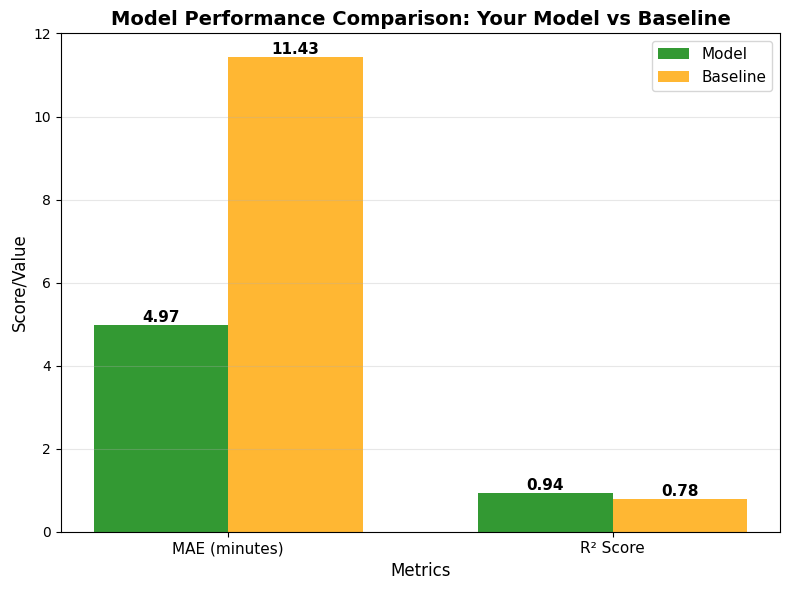

In [28]:
metrics = ['MAE (minutes)', 'R² Score']
model_scores = [mae_model, r2_model]
baseline_scores = [mae_baseline, r2_baseline]
x = np.arange(len(metrics))
width = 0.35
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - width/2, model_scores, width, label='Model', color='green', alpha=0.8)
bars2 = plt.bar(x + width/2, baseline_scores, width, label='Baseline', color='orange', alpha=0.8)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score/Value', fontsize=12)
plt.title('Model Performance Comparison: Your Model vs Baseline', fontsize=14, fontweight='bold')
plt.xticks(x, metrics, fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.annotate(f'{improvement:.2f}% Improvement in MAE', xy=(0.5, max(mae_model, mae_baseline)+1), fontsize=14, fontweight='bold', color='green', ha='center')
plt.tight_layout()
plt.show()